In [1]:
import altair as alt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


N = 100
MAX_DEGREE = 15

np.random.seed(123)

## Overfitting

We simulate a true function $Y$ as a third-order polynomial of $X1$. We show that the error of the fitted function decreases as you increase the complexity of the fitted functions, i.e. fitting polynomials with degree > 3.

In [2]:
# generate data with noise
X1 = np.random.normal(loc=10, scale=5, size=N)
e = np.random.normal(loc=0, scale=2000, size=N)
Y = (2530 + 20*X1 - 10*(X1**2) + 5*(X1**3) + e)

df1 = pd.DataFrame({"Y": Y, "X1": X1})

In [18]:
results1 = pd.DataFrame(columns=["degree", "rmse"])

for n in range(1, MAX_DEGREE + 1):
    poly = PolynomialFeatures(n)
    Xp = poly.fit_transform(df1.iloc[:, 1:])
    fit = LinearRegression().fit(Xp, df1.Y)
    Y_hat = fit.predict(Xp)
    results1 = results1.append(
        {"degree": n, "rmse": np.sqrt(mean_squared_error(df1.Y, Y_hat))},
        ignore_index=True,
    )

alt.Chart(results1).mark_line(point=alt.OverlayMarkDef()).encode(
    x="degree", y="rmse", tooltip=["degree", "rmse"]
)

alt.Chart(...)

## Overfitting with random variables

We now add features $X2, X3$ but keep the true function $Y$ unchanged, i.e. only dependent on $X1$. We show that these random variables may lead to even more severe overfitting.

In [4]:
df2 = df1.copy()
for i in [2, 3]:
    df2[f"X{str(i)}"] = np.random.normal(loc=10, scale=5, size=N)
df2.head()

,Y,X1,X2,X3
0,4174.327280,4.571847,13.516551,13.825274
1,13458.182787,14.986727,7.009473,5.855056
2,10316.618778,11.414892,21.003510,6.704243
3,7790.253500,2.468526,13.441485,13.055618
4,3912.646017,7.106999,9.968464,9.279933


In [5]:
results2 = pd.DataFrame(columns=["degree", "rmse"])

for n in range(1, MAX_DEGREE + 1):
    poly = PolynomialFeatures(n)
    Xp = poly.fit_transform(df2.iloc[:, 1:])
    fit = LinearRegression().fit(Xp, df2.Y)
    Y_hat = fit.predict(Xp)
    results2 = results2.append(
        {"degree": n, "rmse": np.sqrt(mean_squared_error(df2.Y, Y_hat))},
        ignore_index=True,
    )

alt.Chart(results2).mark_line(point=alt.OverlayMarkDef()).encode(
    x="degree", y="rmse", tooltip=["degree", "rmse"]
)


alt.Chart(...)

## Validation to prevent overfitting

We follow [example from sklearn library](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py), with cosine as true function.

In [6]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)


x = np.sort(np.random.rand(30))
y = true_fun(x) + np.random.randn(30) * 0.1
df3 = pd.DataFrame({"y": y, "X": x})

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    df3[["X"]], df3.y, test_size=0.2, random_state=42
)

results3 = pd.DataFrame(columns=["degree", "fold", "rmse"])
for n in range(1, MAX_DEGREE + 1):
    poly = PolynomialFeatures(n)
    Xp_train = poly.fit_transform(X_train)
    Xp_val = poly.fit_transform(X_val)
    lm = LinearRegression().fit(Xp_train, y_train)
    y_hat = lm.predict(Xp_train)
    y_hat_val = lm.predict(Xp_val)
    results3 = results3.append(
        [
            {
                "degree": n,
                "fold": "train",
                "rmse": np.sqrt(mean_squared_error(y_train, y_hat)),
            },
            {
                "degree": n,
                "fold": "validation",
                "rmse": np.sqrt(mean_squared_error(y_val, y_hat_val)),
            },
        ],
        ignore_index=True,
    )

results3 = results3.round(3)

def plot_validation_curve(results):
    base = alt.Chart(results).mark_line(point=alt.OverlayMarkDef()).encode(
        x="degree", y="rmse", color="fold"
    )

    label = alt.selection_single(
        encodings=['x'], # limit selection to x-axis value
        on='mouseover',  # select on mouseover events
        nearest=True,    # select data point nearest the cursor
        empty='none'     # empty selection includes no data points
    )

    return alt.layer(
        base, # base line chart
        
        # add a rule mark to serve as a guide line
        alt.Chart().mark_rule(color='#aaa').encode(
            x='degree'
        ).transform_filter(label),
        
        # add circle marks for selected time points, hide unselected points
        base.mark_circle().encode(
            opacity=alt.condition(label, alt.value(1), alt.value(0))
        ).add_selection(label),

        # add white stroked text to provide a legible background for labels
        base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
            text='rmse:Q'
        ).transform_filter(label),

        # add text labels for stock prices
        base.mark_text(align='left', dx=5, dy=-5).encode(
            text='rmse:Q'
        ).transform_filter(label),
        
        data=results
    )


plot_validation_curve(results3)

alt.LayerChart(...)

## Validation can still lead to overfitting

Validation isn't a 100% safe-guard against overfitting. Given a quadratic (second order) true function, validation still results in a fourth order fitted function.

In [8]:
np.random.seed(456)
X4 = np.random.normal(-10, 6, 250)
e4 = np.random.normal(0, 150, 250)
Y4 = 25 + 2*X4 - 4*(X4**2) + e4

df4 = pd.DataFrame({"y": Y4, "X": X4})

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    df4[["X"]], df4.y, test_size=0.2
)

results4 = pd.DataFrame(columns=["degree", "fold", "rmse"])
for n in range(1, MAX_DEGREE + 1):
    poly = PolynomialFeatures(n)
    Xp_train = poly.fit_transform(X_train)
    Xp_val = poly.fit_transform(X_val)
    lm = LinearRegression().fit(Xp_train, y_train)
    y_hat = lm.predict(Xp_train)
    y_hat_val = lm.predict(Xp_val)
    results4 = results4.append(
        [
            {
                "degree": n,
                "fold": "train",
                "rmse": np.sqrt(mean_squared_error(y_train, y_hat)),
            },
            {
                "degree": n,
                "fold": "validation",
                "rmse": np.sqrt(mean_squared_error(y_val, y_hat_val)),
            },
        ],
        ignore_index=True,
    )

results4 = results4.round(3)
plot_validation_curve(results4).interactive()

alt.LayerChart(...)

## Cross-validation

By using k-fold cross-validation, we have a better safeguard against overfitting. We reproduce the [example from Will Koehrsen](https://github.com/WillKoehrsen/Data-Analysis/blob/master/over_vs_under/Over%20vs%20Under%20Fitting%20Example.ipynb).

In [10]:
def fit_poly(train, y_train, test, y_test, degrees, plot='train', return_scores=False):
    
    # Create a polynomial transformation of features
    features = PolynomialFeatures(degree=degrees, include_bias=False)
    
    # Reshape training features for use in scikit-learn and transform features
    train = train.reshape((-1, 1))
    train_trans = features.fit_transform(train)
    
    # Create the linear regression model and train
    model = LinearRegression()
    model.fit(train_trans, y_train)
    
    # Calculate the cross validation score
    cross_valid = cross_val_score(model, train_trans, y_train, scoring='neg_mean_squared_error', cv = 5)
    
    # Training predictions and error
    train_predictions = model.predict(train_trans)
    training_error = mean_squared_error(y_train, train_predictions)
    
    # Format test features
    test = test.reshape((-1, 1))
    test_trans = features.fit_transform(test)
    
    # Test set predictions and error
    test_predictions = model.predict(test_trans)
    testing_error = mean_squared_error(y_test, test_predictions)
    
    # Find the model curve and the true curve
    x_curve = np.linspace(0, 1, 100)
    x_curve = x_curve.reshape((-1, 1))
    x_curve_trans = features.fit_transform(x_curve)
    
    # Model curve
    model_curve = model.predict(x_curve_trans)
    
    # True curve
    y_true_curve = true_fun(x_curve[:, 0])

     # Return the metrics
    if return_scores:
        return training_error, testing_error, -np.mean(cross_valid)

In [11]:
x = np.sort(np.random.rand(120))
y = true_fun(x) + 0.1 * np.random.randn(len(x))

# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(120)), size = 120, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations
train = xt[:int(0.7 * len(x))]
test = xt[int(0.7 * len(x)):]

y_train = yt[:int(0.7 * len(y))]
y_test = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_fun(x_linspace)

# Range of model degrees to evaluate
degrees = [int(x) for x in np.linspace(1, 40, 40)]

# Results dataframe
results5 = pd.DataFrame(0, columns = ['train_error', 'test_error', 'cross_valid'], index = degrees)

# Try each value of degrees for the model and record results
for degree in degrees:
    degree_results = fit_poly(train, y_train, test, y_test, degree, plot=False, return_scores=True)
    results5.loc[degree, 'train_error'] = degree_results[0]
    results5.loc[degree, 'test_error'] = degree_results[1]
    results5.loc[degree, 'cross_valid'] = degree_results[2]

# print('10 Lowest Cross Validation Errors\n')
# train_eval = results5.sort_values('cross_valid').reset_index(level=0).rename(columns={'index': 'degrees'})
# train_eval.loc[:,['degrees', 'cross_valid']].head(10)

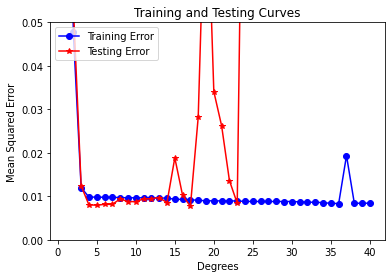


Minimum Training Error occurs at 35 degrees.
Minimum Testing Error occurs at 16 degrees.



In [12]:
import matplotlib.pyplot as plt

plt.plot(results5.index, results5['train_error'], 'b-o', ms=6, label = 'Training Error')
plt.plot(results5.index, results5['test_error'], 'r-*', ms=6, label = 'Testing Error')
plt.legend(loc=2); plt.xlabel('Degrees'); plt.ylabel('Mean Squared Error'); plt.title('Training and Testing Curves');
plt.ylim(0, 0.05); plt.show()

print('\nMinimum Training Error occurs at {} degrees.'.format(int(np.argmin(results5['train_error']))))
print('Minimum Testing Error occurs at {} degrees.\n'.format(int(np.argmin(results5['test_error']))))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2b81cdf-bbde-419b-844b-a10c406c3e76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>